In [1]:
import awkward as awk
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import griddata
import os
import seaborn as sns

sns.set_style('whitegrid')

In [27]:
TPC_boxes = np.array(
    [0, 0, -0.375, 1.7, 1.96, 0.563]
) # TPC dimensions extracted from Matheus' paper

def is_points_in_boxes(points, boxes):
    points = np.asarray(points)
    boxes = np.asarray(boxes)
    centers, dimensions = boxes[:3], boxes[3:]
    
    # Broadcasting to compare all points with all boxes
    in_bounds = np.all(
        (points[:, np.newaxis, :] >= centers - dimensions/2) & 
        (points[:, np.newaxis, :] <= centers + dimensions/2),
        axis=2
    )

    # Check if each point is in any box
    return np.any(in_bounds, axis=1)

filename = '/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/msliu/output_final/ND280UPGRD_Dipole_M1.00e-02_mu1.00e-07_example.parquet'

data = awk.from_parquet(filename)

dec_flag = data["primary_type"] == 5914
fid_flag = data["in_fiducial"][dec_flag]

print(data["in_fiducial"])
print(fid_flag)

[[False, False], [False, False], [...], ..., [False, False], [False, False]]
[[False], [False], [False], [True], ..., [False], [False], [False], [False]]


In [29]:
FGD_boxes = np.array([
    [0, 0, -0.375, 1.843,1.843, 0.288],
    [0, 0, 0.99, 1.843,1.843, 0.288]
]) # TPC dimensions extracted from Matheus' paper

def is_points_in_boxes(points, boxes):
    points = np.asarray(points)
    boxes = np.asarray(boxes)
    centers, dimensions = boxes[:, :3], boxes[:, 3:]
    
    # Broadcasting to compare all points with all boxes
    in_bounds = np.all(
        (points[:, np.newaxis, :] >= centers - dimensions/2) & 
        (points[:, np.newaxis, :] <= centers + dimensions/2),
        axis=2
    )

    # Check if each point is in any box
    return np.any(in_bounds, axis=1)

data = awk.from_parquet("/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/msliu/output_final/ND280UPGRD_Dipole_M1.00e-02_mu1.00e-07_example.parquet")
pts = data['vertex'][:,1]
# fid_flag = data["in_fiducial"][dec_flag]
# weights = np.array(np.squeeze(data['event_weight'] * fid_flag * (POT['ND280NU'])))is_points_in_boxes(pts, FGD_boxes)
N_momenta = np.squeeze(data["primary_momentum"][data["primary_type"] == 5914])
weights = np.array(np.array(data['event_weight'] * is_points_in_boxes(data['vertex'][:,1], FGD_boxes)) )
mask = np.logical_not(np.isnan(weights))
N_momenta[mask,:]

<Array [[0.378, -0.000403, ..., 0.378], ..., [...]] type='100000 * 4 * float64'>

# Extract Gas TPC MC Samples

In [2]:
POT = 2.6098758621e22

n_m = 10
n_mu = 10
m_sample = np.geomspace(1e-2,2,n_m)
mu_sample = np.geomspace(1e-7,1e-5,n_mu)
m_sample, mu_sample = np.meshgrid(m_sample, mu_sample)
m_sample = np.reshape(m_sample,[n_m*n_mu])
mu_sample = np.reshape(mu_sample,[n_m*n_mu])

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans", "Helvetica", "sans-serif"],
    "mathtext.fontset": "dejavusans",
    'font.size': 16,
    'image.cmap': 'YlGnBu',
})

In [3]:
POT = 2.6098758621e22
POTOGNeu = 1.234e21
POTOGAnti = 6.29e20

new_sample = np.array([])
new_points = np.array([])

recording = np.array([])

def extract_data():
    with open('./OGTPC3.txt', 'w') as r, open('./OGTPC3.txt', 'w') as n:

        for m4, tr4 in zip(m_sample, mu_sample):

            path="OGTPC3_Dipole_M%2.2e_mu%2.2e_example.parquet"%(m4,tr4)
            
            if os.path.isfile('./output/'+path):
                data = awk.from_parquet("output/"+path)
                flag = data["secondary_types"]==22 * data["in_fiducial"]
                result = [m4,tr4,np.sum(np.transpose(data["event_weight"]*flag*POTOGNeu)[1][1])*0.0006]
                result_string = ', '.join([f'{x:.16e}' for x in result])
                r.write(result_string+'\n')
                # f.write(f"{[m4,tr4,np.sum(np.transpose(data["event_weight"]*flag*POT)[1][1])*0.0006]}\n") 
            else:
                result_string = ', '.join([f'{x:.16e}' for x in [m4,tr4]])
                n.write(result_string+'\n')
            
    return "Extraction finished"

extract_data()

In [7]:
def get_data(path): 
    
    x = []
    y = []
    z = []   
    
    with open(path,'r') as f:
        lines = f.readlines()
        for line in lines:
            i, ii, iii = line.strip().split(', ')
            x += [np.log10(float(i)*1000)]
            # convert d = mu/2
            y += [np.log10(float(ii)/2)]
            z += [np.log10(float(iii))]
        x = np.array(x)
        y = np.array(y)
        z = np.array(z)
        
    return x, y, z

In [ ]:
import pandas as pd
def get_data_csv(path):
    # Read processed signals
    df = pd.read_csv(path, usecols=['Experiment','i','Mass','Coupling','Signal_Strength'])
    processed_list = np.array([f"{exp}_{i}" for exp, i in zip(df.iloc[:, 0].tolist(), df.iloc[:, 1].tolist())])
    
    data = {}
    for exp, i in zip(df.iloc[:,0].tolist(),df.iloc[:,1].tolist()):
        data[[exp,i]]=

## Sum Event Counts from TPCs

In [23]:
def read_coordinates(filename):
    coordinates = {}
    with open(filename, 'r') as file:
        for line in file:
            data = line.strip().split(', ')
            if len(data) >= 3:
                x, y, z = float(data[0]), float(data[1]), float(data[2])
                coordinates[(x, y)] = z
    return coordinates

def sum_z_coordinates(file_list, year):
    sum_coordinates = {}

    for filename in file_list:
        coords = read_coordinates(filename)
        for (x, y), z in coords.items():
            if (x, y) in sum_coordinates:
                # Crude 10% cut from Abe 2020
                sum_coordinates[(x, y)] += z*year/10*0.1
            else:
                # Crude 10% cut from Abe 2020
                sum_coordinates[(x, y)] = z*year/10*0.1
    
    return sum_coordinates

def write_sum_file(sum_coordinates, output_file):
    with open(output_file, 'w') as file:
        for (x, y), z in sum_coordinates.items():
            # file.write(f"{x} {y} {z}\n")
            file.write(f'{x:.16e}'+', '+f'{y:.16e}'+', '+f'{z:.16e}'+'\n')

# List of input files
input_files = ['./TPC1.txt', './TPC2.txt', './TPC3.txt', './TPC4.txt', './TPC5.txt']
OG_input_files = ['./OGTPC1.txt', './OGTPC2.txt', './OGTPC3.txt']

# Sum z-coordinates
result = sum_z_coordinates(OG_input_files, 10)

# Write the result to sum.txt
write_sum_file(result, 'sum_ND280.txt')

print("Processing complete. Results written to sum_ND280.txt")

Processing complete. Results written to sum_ND280.txt


## Rejection Likelihood 95% CL

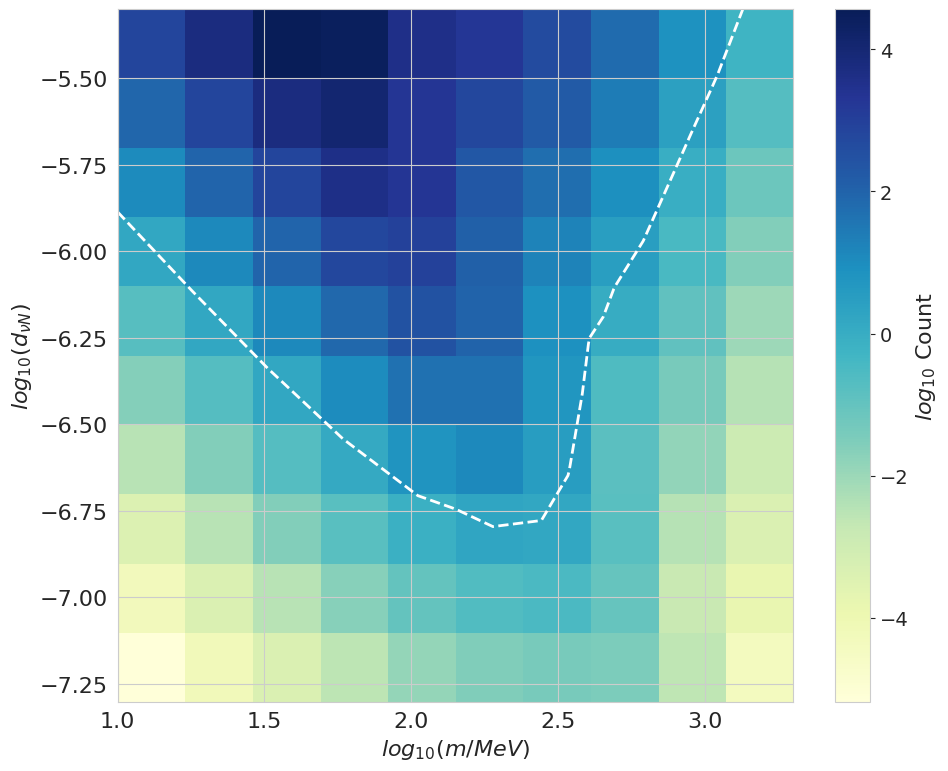

In [10]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans", "Helvetica", "sans-serif"],
    "mathtext.fontset": "dejavusans",
    'font.size': 16,
    'image.cmap': 'YlGnBu',
})

def create_pixel_plot(x, y, z):
    # Sort the points based on x and y coordinates
    sorted_indices = np.lexsort((y, x))
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    z_sorted = z[sorted_indices]

    # Get unique x and y values
    x_unique = np.unique(x_sorted)
    y_unique = np.unique(y_sorted)

    # Create a 2D grid for the z values
    z_grid = np.full((len(y_unique), len(x_unique)), np.nan)

    # Fill the grid with z values
    for i, (xi, yi, zi) in enumerate(zip(x_sorted, y_sorted, z_sorted)):
        x_idx = np.where(x_unique == xi)[0][0]
        y_idx = np.where(y_unique == yi)[0][0]
        z_grid[y_idx, x_idx] = zi

    # Create the pixel plot
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(z_grid, origin='lower', extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()],
                   aspect='auto') # Set aspect to 'auto'
    plt.colorbar(im, label='$log_{10}$ Count')
    ax.set_xlabel(r'$log_{10}(m/MeV)$', fontsize=16)
    ax.set_ylabel(r'$log_{10}(d_{\nu N})$', fontsize=16)

    # Create x-y grid for interpolation
    xi = np.linspace(x_unique.min(), x_unique.max(), 100)
    yi = np.linspace(y_unique.min(), y_unique.max(), 100)
    Xi, Yi = np.meshgrid(xi, yi)

    # Interpolate the data onto the grid
    Zi = griddata((x_sorted, y_sorted), z_sorted, (Xi, Yi), method='linear')

    contour_line = plt.contour(Xi, Yi, Zi, levels=[np.log10(np.log(1/0.05))], colors='white', linestyles='dashed', linewidths=2)

    # Write contour data to file
    with open('contour_data_3y.txt', 'w') as f:
        level = np.log10(np.log(1/0.05))
        f.write(f"Contour Level: {level}\n")
        for path in contour_line.allsegs[0]:
            for x, y in path:
                f.write(f"{x:.6f}\t{y:.6f}\n")
            f.write("\n")

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xscale('linear')
    plt.yscale('linear')

    # Adjust the plot to fill the figure
    plt.tight_layout()
    plt.savefig('./figures/pixel+.pdf')
    plt.show()
    
x, y, z = get_data('./sum_ND280+.txt')
create_pixel_plot(x, y, z)

m_sample_new

/tmp/ipykernel_1264659/1089287454.py:42: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for i, collection in enumerate(contour_line.collections):


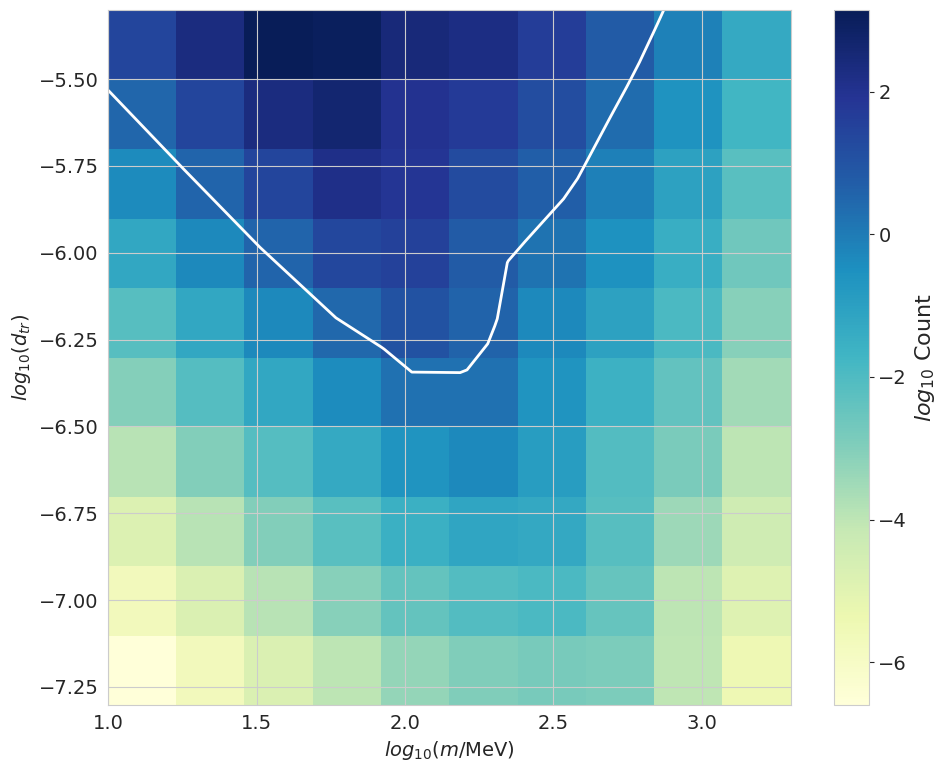

In [24]:

def create_pixel_plot_OG(x, y, z):
         
    # Sort the points based on x and y coordinates
    sorted_indices = np.lexsort((y, x))
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    z_sorted = z[sorted_indices]

    # Get unique x and y values
    x_unique = np.unique(x_sorted)
    y_unique = np.unique(y_sorted)

    # Create a 2D grid for the z values
    z_grid = np.full((len(y_unique), len(x_unique)), np.nan)

    # Fill the grid with z values
    for i, (xi, yi, zi) in enumerate(zip(x_sorted, y_sorted, z_sorted)):
        x_idx = np.where(x_unique == xi)[0][0]
        y_idx = np.where(y_unique == yi)[0][0]
        z_grid[y_idx, x_idx] = zi

    # Create the pixel plot
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(z_grid, origin='lower', extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()],
                   aspect='auto')  # Set aspect to 'auto'
    plt.colorbar(im, label='$log_{10}$ Count')
    ax.set_xlabel('$log_{10}(m$/MeV$)$', fontsize = 14)
    ax.set_ylabel('$log_{10}( d_{tr} )$', fontsize = 14)
    
    # Create x-y grid for interpolation
    xi = np.linspace(x_unique.min(), x_unique.max(), 100)
    yi = np.linspace(y_unique.min(), y_unique.max(), 100)
    Xi, Yi = np.meshgrid(xi, yi)
    
    # Interpolate the data onto the grid
    Zi = griddata((x_sorted, y_sorted), z_sorted, (Xi, Yi), method='linear')
    contour_line = plt.contour(Xi, Yi, Zi, levels=[np.log10(np.log(1/0.05))], colors='white', linestyles='solid', linewidths=2)
    # plt.clabel(contour_line, inline=True, fontsize=10, fmt='%1.1f')

    # Open a file to write the contour data
    with open('OG_contour_total.txt', 'w') as f:
        for i, collection in enumerate(contour_line.collections):
            level = [np.log10(np.log(1/0.05))]
            for path in collection.get_paths():
                vertices = path.vertices
                f.write(f"Contour Level: {level}\n")
                for x, y in vertices:
                    f.write(f"{x:.6f}\t{y:.6f}\n")
                f.write("\n")
                
    # ax = plt.gca()
    # ax.set_xlim([1.5, 3.0])
    # ax.set_ylim([-7.0, -6.0])
                
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xscale('linear')
    plt.yscale('linear')
    
    # Adjust the plot to fill the figure
    plt.tight_layout()
    plt.savefig('./figures/pixel.pdf')
    plt.show()

x, y, z = get_data('./sum_ND280.txt')
create_pixel_plot_OG(x, y, z)

In [5]:
i=66
m4, tr4 = m_sample[i], mu_sample[i]

path="TPC2_Dipole_M%2.2e_mu%2.2e_example.parquet"%(m4,tr4)

if os.path.isfile('./output/'+path):
    data = awk.from_parquet("output/"+path)

dist = []

for pts in data['vertex']:
    [a, b]= pts
    dist += [np.linalg.norm(a-b)]

# Load the NumPy array (if saved in a file)
# data = np.load('path_to_your_array.npy')

# If the array is already in memory, use it directly:

logdist = np.log10(dist)

In [6]:
weight = data['event_weight']

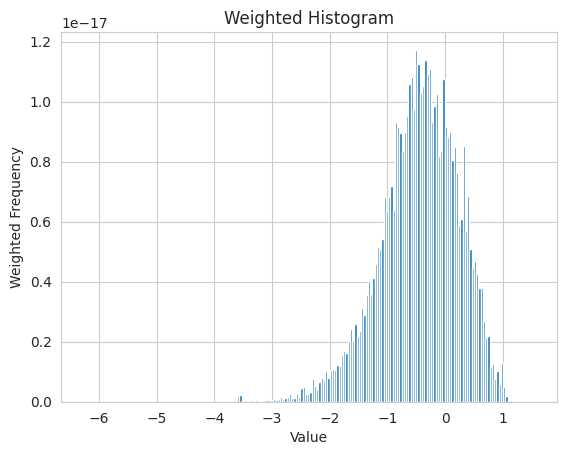

In [8]:
hist, bin_edges = np.histogram(logdist, weights=weight, bins=200)   
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align="edge")
plt.xlabel('Value')
plt.ylabel('Weighted Frequency')
plt.title('Weighted Histogram')
plt.show()

In [7]:
def weighted_median(data, weights):
    """Calculate the weighted median of a list of values."""
    data, weights = np.array(data), np.array(weights)
    s_data, s_weights = map(np.array, zip(*sorted(zip(data, weights))))
    midpoint = 0.5 * sum(s_weights)
    if any(weights > midpoint):
        w_median = (data[weights == np.max(weights)])[0]
    else:
        cs_weights = np.cumsum(s_weights)
        idx = np.where(cs_weights <= midpoint)[0][-1]
        if cs_weights[idx] == midpoint:
            w_median = np.mean(s_data[idx:idx+2])
        else:
            w_median = s_data[idx+1]
    return w_median

Maximum value: 1.5543517232434894
Minimum value: -6.265543038398128
Weighted Median: -0.4057631666252467


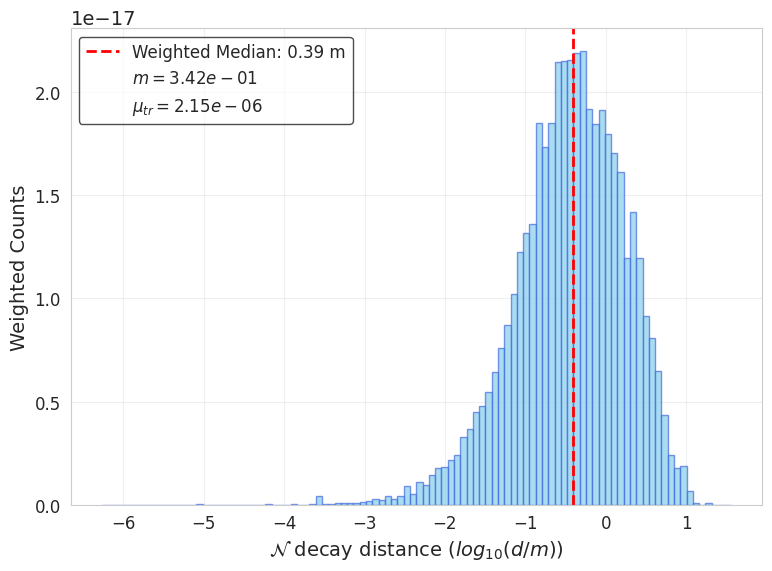

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

sns.axes_style('whitegrid')

# Assuming these functions and variables are defined elsewhere
# weighted_median, logdist, weight, m4, tr4

# Convert inputs to numpy arrays if they aren't already
logdist = np.asarray(logdist)
weight = np.asarray(weight)

# Print out the max and minimum values
logdist_max = np.max(logdist)
logdist_min = np.min(logdist)
weighted_med = weighted_median(logdist, weight)
print(f"Maximum value: {logdist_max}")
print(f"Minimum value: {logdist_min}")
print(f"Weighted Median: {weighted_med}")

# Create the weighted histogram
plt.figure(figsize=(8, 4))

# Calculate the weighted histogram
hist, bin_edges = np.histogram(logdist, bins=100, weights=weight)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the histogram
plt.bar(bin_centers, hist, width=np.diff(bin_edges), alpha=0.7, color='skyblue', edgecolor='royalblue')

# Customize the plot
plt.xlabel(r'$\mathcal{N}$ decay distance ($log_{10}(d/m)$)', fontsize=14)
plt.ylabel("Weighted Counts", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

print_weighted_med = np.power(10, weighted_med)

# Add vertical line for weighted median
plt.axvline(weighted_med, color='red', linestyle='dashed', linewidth=2, label=f'Weighted Median: {print_weighted_med:.2e} m')

plt.grid(True, alpha=0.3)

# Create a custom legend with both the original legend items and the m and mu values
legend_elements = [
    Line2D([0], [0], color='red', linestyle='dashed', lw=2, label=f'Weighted Median: {print_weighted_med:.2f} m'),
    Patch(facecolor='none', edgecolor='none', label=fr'$m = {m4:.2e}$'),
    Patch(facecolor='none', edgecolor='none', label=fr'$\mu_{{tr}} = {tr4:.2e}$')
]

# Add the legend to the plot
plt.legend(handles=legend_elements, loc='upper left', fontsize=12, framealpha=0.7, edgecolor='black')

# Show the plot
plt.tight_layout()
plt.savefig('./figures/length.pdf')
plt.show()


In [37]:
import numpy as np
import os
import awkward as awk
from tqdm import tqdm

POT = 2.6098758621e22
weighted_med = {}

m_1 = m_sample[:10]


# Wrap the zip object with tqdm for the progress bar
for m4, tr4 in tqdm(zip(m_sample, mu_sample), total=len(m_sample), desc="Processing samples"):
    path = "ND280UPGRD_Dipole_M%2.2e_mu%2.2e_example.parquet" % (m4, tr4)
    if os.path.isfile('./output/' + path):
        data = awk.from_parquet("output/" + path)
        weight = data['event_weight']
        dist = []
        for pts in data['vertex']:
            [a, b] = pts
            dist.append(np.linalg.norm(a - b))
        weighted_med[(m4, tr4)] = weighted_median(dist, weight)

def extract_xyz(data_dict):
    # Extract the keys and values
    keys = np.array(list(data_dict.keys()))
    values = np.array(list(data_dict.values()))
    # Split the keys into x and y
    x = keys[:, 0]
    y = keys[:, 1]
    # The values are already z
    z = values
    return x, y, z

x, y, z = extract_xyz(weighted_med)

Processing samples:   6%|▌         | 6/100 [06:22<1:46:23, 67.91s/it]

In [12]:
[m1, m2, m3, m4, m5, m6, m7, m8, m9, m10]=np.split(m_sample,10)
[mu1, mu2, mu3, mu4, mu5, mu6, mu7, mu8, mu9, mu10]=np.split(mu_sample,10)

In [13]:
import numpy as np
import os
import awkward as awk
from tqdm import tqdm

POT = 2.6098758621e22
weighted_med = {}

m_1 = m_sample[:10]


# Wrap the zip object with tqdm for the progress bar
for m4, tr4 in tqdm(zip(m_sample, mu_sample), total=len(m_sample), desc="Processing samples"):
    path = "ND280UPGRD_Dipole_M%2.2e_mu%2.2e_example.parquet" % (m4, tr4)
    if os.path.isfile('./output/' + path):
        data = awk.from_parquet("output/" + path)
        weight = data['event_weight']
        dist = []
        for pts in data['vertex']:
            [a, b] = pts
            dist.append(np.linalg.norm(a - b))
        weighted_med[(m4, tr4)] = weighted_median(dist, weight)

def extract_xyz(data_dict):
    # Extract the keys and values
    keys = np.array(list(data_dict.keys()))
    values = np.array(list(data_dict.values()))
    # Split the keys into x and y
    x = keys[:, 0]
    y = keys[:, 1]
    # The values are already z
    z = values
    return x, y, z

x, y, z = extract_xyz(weighted_med)

array([0.01      , 0.01801648, 0.03245936, 0.05848035, 0.10536103,
       0.18982351, 0.34199519, 0.61615503, 1.11009462, 2.        ])

In [19]:
import multiprocessing 

def extract_xyz(data_dict):
    # Extract the keys and values
    keys = np.array(list(data_dict.keys()))
    values = np.array(list(data_dict.values()))
    
    # Split the keys into x and y
    x = keys[:, 0]
    y = keys[:, 1]
    
    # The values are already z
    z = values
    
    return x, y, z

def decay_distance(m4, tr4):
    
    path="TPC2_Dipole_M%2.2e_mu%2.2e_example.parquet"%(m4,tr4)
    
    if os.path.isfile('./output/'+path):
        data = awk.from_parquet("output/"+path)
    
    weight = data['event_weight']
    dist = []

    for pts in data['vertex']:
        [a, b]= pts
        dist += [np.linalg.norm(a-b)]
        
    return [m4, tr4, weighted_median(dist, weight)]

def save_results_to_file(results, filename):
    with open(filename, 'w') as file:
        for result in results:
            file.write(f"{result}\n")

def parallel_process(data1, data2):
    # Determine the number of CPU cores to use
    num_cores = multiprocessing.cpu_count()
    
    # Create a pool of worker processes
    with multiprocessing.Pool(processes=int(num_cores)) as pool:
        # Use starmap to pass multiple arguments to the worker function
        results = pool.starmap(decay_distance, zip(data1, data2))
    
weighted_med = {}

results = parallel_process(m_sample, mu_sample)

output_filename = "./flux.dat"
save_results_to_file(results, output_filename)

print(f"Results have been saved to {output_filename}")

In [28]:
import numpy as np

x = []; y = []; z = []

with open('distance.txt') as d:
    next(d)
    for line in d:
        i, ii, iii = line.strip().split()
        
        x.append(float(i))
        y.append(float(ii))
        z.append(float(iii))
        
[x, y, z] = [np.array(x), np.array(y), np.array(z)]
z = np.log10(z)
        

<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_4044095/678198442.py:47: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title('$\mathcal{N}$ Decay Distance', fontsize=20)
/tmp/ipykernel_4044095/678198442.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=12)


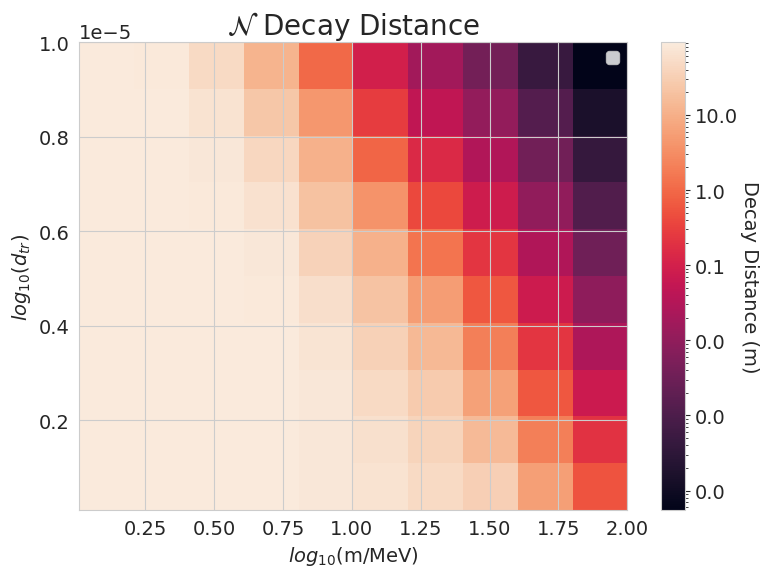

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.size":14,
    # "font.serif": ["Tahoma"],
    "mathtext.fontset": "dejavusans"
})

def distance_pixel_plot(x, y, z, line_intercept=0):
    # Sort the points based on x and y coordinates
    sorted_indices = np.lexsort((y, x))
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    z_sorted = z[sorted_indices]

    # Get unique x and y values
    x_unique = np.unique(x_sorted)
    y_unique = np.unique(y_sorted)

    # Create a 2D grid for the z values
    z_grid = np.full((len(y_unique), len(x_unique)), np.nan)

    # Fill the grid with z values
    for i, (xi, yi, zi) in enumerate(zip(x_sorted, y_sorted, z_sorted)):
        x_idx = np.where(x_unique == xi)[0][0]
        y_idx = np.where(y_unique == yi)[0][0]
        z_grid[y_idx, x_idx] = zi

    # Create the pixel plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Use LogNorm for the color scale
    im = ax.imshow(z_grid, origin='lower', 
                   extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()],
                   aspect='auto', norm=LogNorm())
    
    # Add a logarithmic colorbar
    cbar = plt.colorbar(im, label='Count', format='%1.1f')
    cbar.set_label('Decay Distance (m)', rotation=270, labelpad=15)

    ax.set_xlabel('$log_{10}$(m/MeV)', fontsize=14)
    ax.set_ylabel('$log_{10}( d_{tr} )$', fontsize=14)
    ax.set_title('$\mathcal{N}$ Decay Distance', fontsize=20)

    # Add the y = -3x + intercept line
    # x_line = np.array([x_unique.min(), x_unique.max()])
    # y_line = -3 * x_line + line_intercept
    # ax.plot(x_line, y_line, 'w--', linewidth=2, label=f'y = -3x + {line_intercept}')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Set x and y scales to linear (since the data is already in log scale)
    
    
    plt.xscale('linear')
    plt.yscale('linear')

    # Add legend
    ax.legend(fontsize=12)

    # Adjust the plot to fill the figure
    plt.tight_layout()
    plt.show()

# Assuming x, y, and z are your data arrays
# You can adjust the intercept value as needed
distance_pixel_plot(x, y, z, line_intercept=2)

In [5]:
mN=100
r = 0.51099895069/mN
L = lambda r : ( 2 - r**6/8 ) * np.arccosh(1/r) - ( 24 - 10*r**2 + r**4) * np.sqrt(1-4*r**2) / 8
print(L(r))
E = []
count = []
with open('flux.dat', 'r') as f:
        for line in f.readlines():
            E0,count0 = line.strip().split()
            E.append(float(E0))
            count.append(float(count0))
print(E)
print(count)

8.939586475670255
[0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.07500000000000001, 0.08499999999999999, 0.095, 0.10500000000000001, 0.11499999999999999, 0.125, 0.135, 0.14500000000000002, 0.155, 0.165, 0.175, 0.185, 0.195, 0.20500000000000002, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265, 0.275, 0.28500000000000003, 0.295, 0.305, 0.315, 0.325, 0.335, 0.345, 0.355, 0.365, 0.375, 0.385, 0.395, 0.405, 0.415, 0.425, 0.435, 0.445, 0.455, 0.46499999999999997, 0.475, 0.485, 0.495, 0.505, 0.515, 0.525, 0.535, 0.545, 0.555, 0.565, 0.575, 0.585, 0.595, 0.605, 0.615, 0.625, 0.635, 0.645, 0.655, 0.665, 0.675, 0.685, 0.695, 0.705, 0.715, 0.725, 0.735, 0.745, 0.755, 0.765, 0.775, 0.785, 0.795, 0.81, 0.83, 0.85, 0.87, 0.89, 0.925, 0.975, 1.025, 1.0750000000000002, 1.125, 1.1749999999999998, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05, 2.1500000000000004, 2.25, 2.3499999999999996, 2.5, 2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.25, 4.75, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5

In [54]:
'%2.2e'%(np.power(10,-1.2))

'6.31e-02'

<>:115: SyntaxWarning: invalid escape sequence '\m'
<>:115: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_317287/4211873701.py:115: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$\mu_{tr}$')
Calculating distances: 100%|██████████| 500/500 [01:50<00:00,  4.51it/s]
/tmp/ipykernel_317287/4211873701.py:99: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for i, collection in enumerate(contour.collections):


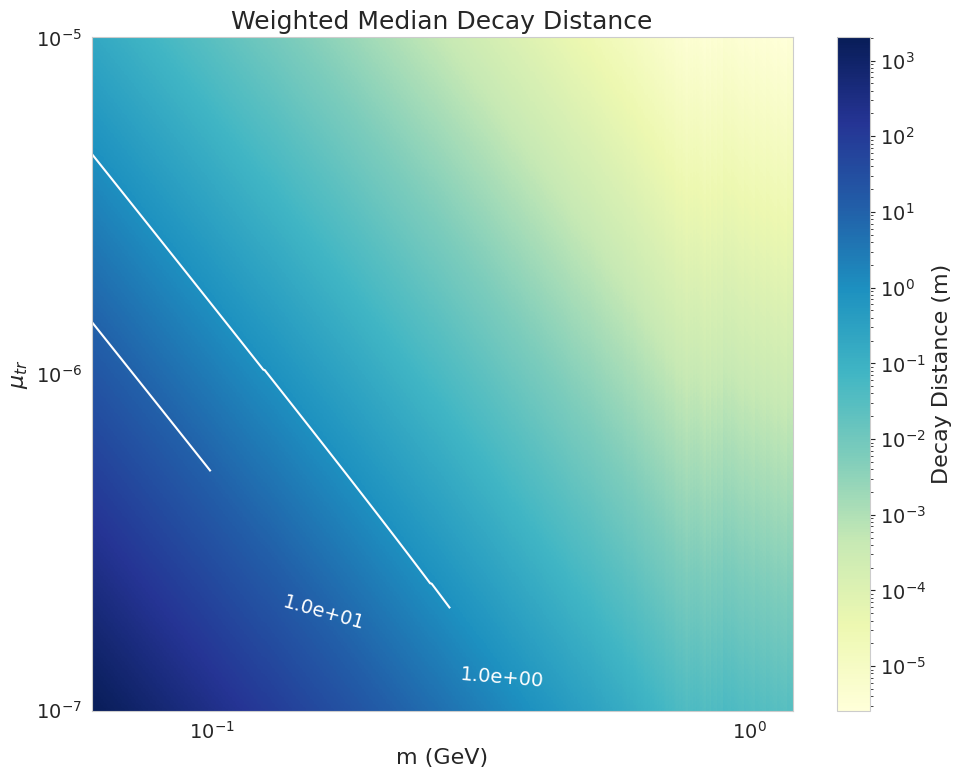

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm

# def calculate_decay_distance(E, mN, mu):
    
#     # Constants
#     hbar = 1.0545718e-34  # Reduced Planck constant (J·s)
#     c = 2.998e8           # Speed of light (m/s)
#     alpha = 1/137         # Fine structure constant
#     r = 0.00051099895069/mN    # Electron mass ratio in GeV
#     L = lambda r : ( 2 - r**6/8 ) * np.arccosh(1/r) - ( 24 - 10*r**2 + r**4) * np.sqrt(1-4*r**2) / 8    # Expression

#     return (48 * np.pi**2 * np.sqrt(((E/mN)**2-1)) ) / (alpha * L(r) * mu**2 * mN**3) * hbar * c**2

def calculate_decay_distance(E, mN, mu):
    
    # Constants
    hbar = 1.0545718e-34  # Reduced Planck constant (J·s)
    c = 2.998e8           # Speed of light (m/s)

    return (16 * np.pi * np.sqrt(((E/mN)**2-1)) ) / ( mu**2 * mN**3) * hbar * c**2

def energy_filter(energy, M):
#sufficient energy to produce HNL
    if energy>=M:
        return True
    else:
        return False

def weighted_median_decay_distance(file_path, M, Mu):
    # Load data from the .dat file
    data = np.loadtxt(file_path)
    energies = data[:, 0]
    weights = data[:, 1]
    
    # Apply filter to energies
    mask = np.vectorize(lambda e: energy_filter(e, M))(energies)
    filtered_energies = energies[mask]
    filtered_weights = weights[mask]
    
    # Calculate decay distances for filtered energies
    decay_distances = calculate_decay_distance(filtered_energies, M, Mu)
    
    # Sort decay distances and weights
    sorted_indices = np.argsort(decay_distances)
    sorted_distances = decay_distances[sorted_indices]
    sorted_weights = filtered_weights[sorted_indices]
    
    # Calculate cumulative weights
    cumulative_weights = np.cumsum(sorted_weights)
    total_weight = cumulative_weights[-1]
    
    # Find the index where cumulative weight exceeds half of the total weight
    median_index = np.searchsorted(cumulative_weights, total_weight / 2)
    
    # Return the median decay distance
    return sorted_distances[median_index]

# # Example usage
# file_path = 'flux.dat'
# M = 1.0  # Replace with your desired M value
# Mu = 1e-6  # Replace with your desired Mu value

# result = weighted_median_decay_distance(file_path, M, Mu)
# print(f"The weighted median decay distance is: {result}")


def plot_decay_distance_heatmap(m_range, mu_range, num_points=100, num_contours=10):
    # Create linearly spaced points for m and mu
    m_values = np.geomspace(m_range[0], m_range[1], num_points)
    mu_values = np.geomspace(mu_range[0], mu_range[1], num_points)
    
    # Create meshgrid for contour plot
    M, MU = np.meshgrid(m_values, mu_values)
    
    # Initialize the distance array
    distances = np.zeros((num_points, num_points))
    
    # Calculate the decay distance for each pair of m and mu
    for i, m in enumerate(tqdm(m_values, desc="Calculating distances")):
        for j, mu in enumerate(mu_values):
            distances[j, i] = weighted_median_decay_distance('flux.dat',m, mu)
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create the heatmap
    im = ax.pcolormesh(m_values, mu_values, distances, norm=LogNorm(), shading='auto')
    
    # Add contour lines
    level = [1,10]
    contour = ax.contour(M, MU, distances, levels=level, colors='white', alpha=1)
    ax.clabel(contour, inline=True, fontsize=14, fmt='%.1e')
    
    # Save contour data
    with open('analytic_distance_contour.txt', 'w') as f:
        for i, collection in enumerate(contour.collections):
            for path in collection.get_paths():
                vertices = path.vertices
                f.write(f"Contour Level: {level[i]}\n")
                for x, y in vertices:
                    f.write(f"{x:.16f}\t{y:.16f}\n")
                f.write("\n")
            
    # Colorbar
    cbar = fig.colorbar(im, ax=ax, label='Decay Distance (m)')
    cbar.ax.yaxis.set_tick_params(which='both', direction='out')
    
    # Set scale and labels
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('m (GeV)')
    ax.set_ylabel('$\mu_{tr}$')
    ax.set_title('Weighted Median Decay Distance')
    
    plt.tight_layout()
    plt.show()

# Example usage
m_range = (6e-2, 1.2)  # GeV
mu_range = (1e-7, 1e-5)  # mu

plot_decay_distance_heatmap(m_range, mu_range, num_points=500)


<>:59: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:94: SyntaxWarning: invalid escape sequence '\m'
<>:59: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:94: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_54813/1812607318.py:59: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('$log_{10}(m/\mathrm{MeV})$', fontsize=14)
/tmp/ipykernel_54813/1812607318.py:61: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title('$\mathcal{N}$ Decay Distance in ND280+', fontsize=20)
/tmp/ipykernel_54813/1812607318.py:94: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(x_line, y_line, 'r--', linewidth=2, label=f'$|d_\mu|^2\propto m_N^3$')


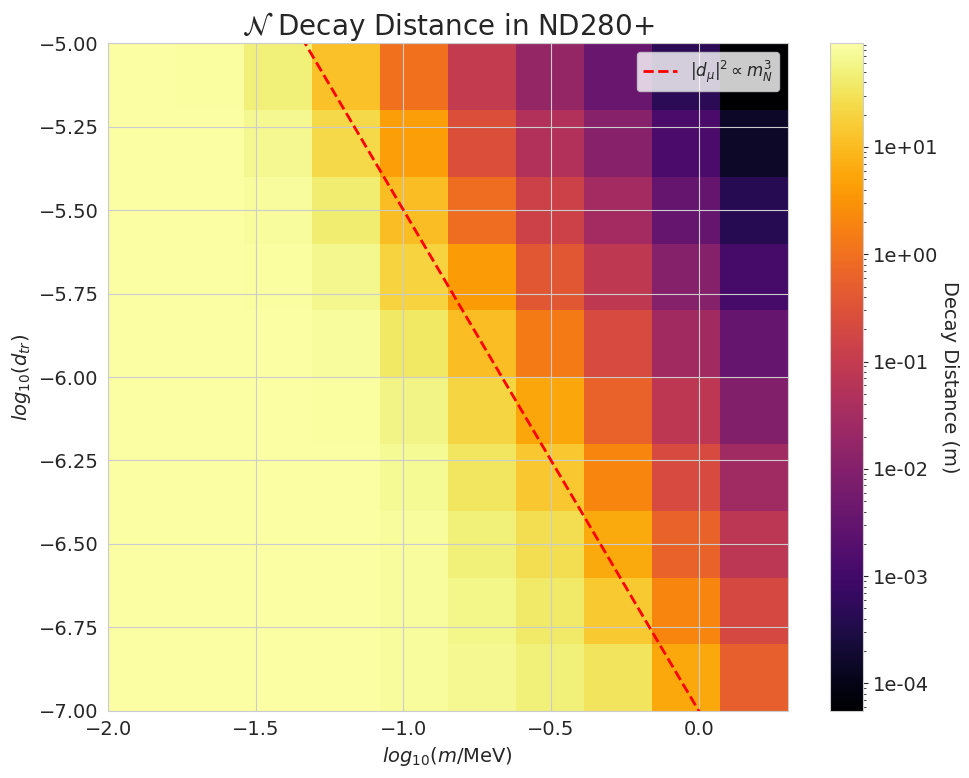

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

plt.rcParams.update({'text.usetex': False,'font.size': 14, 'font.family':'sans-serif', 'mathtext.fontset': 'dejavusans'})

def read_data(filename):
    # Read the data from the file, skipping the header
    x = []; y = []; z = []
    with open(filename) as d:
        next(d)
        for line in d:
            i, ii, iii = line.strip().split()
            x.append(float(i))
            y.append(float(ii))
            z.append(float(iii))
    [x, y, z] = [np.array(x), np.array(y), np.array(z)]
    return x, y, z

def distance_pixel_plot(x, y, z, line_intercept=0):
    # Convert x and y to log scale
    x_log = np.log10(x)
    y_log = np.log10(y)

    # Sort the points based on x and y coordinates
    sorted_indices = np.lexsort((y, x))
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    z_sorted = z[sorted_indices]

    # Create a grid for the pixel plot
    x_unique = np.unique(x_log)
    y_unique = np.unique(y_log)
    
    # Create a 2D array to hold the z values
    z_grid = np.full((len(y_unique), len(x_unique)), np.nan)

    # Fill the grid with z values
    for xi, yi, zi in zip(x_log, y_log, z):
        x_idx = np.argmin(np.abs(x_unique - xi))
        y_idx = np.argmin(np.abs(y_unique - yi))
        z_grid[y_idx, x_idx] = zi


    # Create the pixel plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Use LogNorm for the color scale, with a small epsilon to avoid log(0)
    epsilon = 1e-10
    im = ax.imshow(z_grid, origin='lower', 
                   extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()],
                   aspect='auto', norm=LogNorm(vmin=max(np.nanmin(z_grid), epsilon)),
                   cmap='inferno')
    
    # Add a logarithmic colorbar
    cbar = plt.colorbar(im, label='Decay Distance (m)', format='%.0e')
    cbar.set_label('Decay Distance (m)', rotation=270, labelpad=15)

    ax.set_xlabel('$log_{10}(m/\mathrm{MeV})$', fontsize=14)
    ax.set_ylabel('$log_{10}(d_{tr})$', fontsize=14)
    ax.set_title('$\mathcal{N}$ Decay Distance in ND280+', fontsize=20)
    # Create x-y grid for interpolation
    xi = np.linspace(x_unique.min(), x_unique.max(), 100)
    yi = np.linspace(y_unique.min(), y_unique.max(), 100)
    Xi, Yi = np.meshgrid(xi, yi)
    
    # Interpolate the data onto the grid
    Zi = griddata((x_sorted, y_sorted), z_sorted, (Xi, Yi), method='linear')
    contour_line_1 = plt.contour(Xi, Yi, Zi, levels=[1], colors='white', linestyles='dashed', linewidths=2)
    contour_line_2 = plt.contour(Xi, Yi, Zi, levels=[0], colors='white', linestyles='dashed', linewidths=2)
    contour_line_3 = plt.contour(Xi, Yi, Zi, levels=[-1], colors='white', linestyles='dashed', linewidths=2)
    contour_line_4 = plt.contour(Xi, Yi, Zi, levels=[-2], colors='white', linestyles='dashed', linewidths=2)
    contour_line_5 = plt.contour(Xi, Yi, Zi, levels=[-6], colors='white', linestyles='dashed', linewidths=2)
    plt.clabel(contour_line_1, inline=True, fontsize=10, fmt='%1.1f')
    plt.clabel(contour_line_2, inline=True, fontsize=10, fmt='%1.1f')
    plt.clabel(contour_line_3, inline=True, fontsize=10, fmt='%1.1f')
    plt.clabel(contour_line_4, inline=True, fontsize=10, fmt='%1.1f')
    plt.clabel(contour_line_5, inline=True, fontsize=10, fmt='%1.1f')

    # # Open a file to write the contour data
    # with open('contour_data_3y.txt', 'w') as f:
    #     for i, collection in enumerate(contour_line.collections):
    #         level = [np.log10(np.log(1/0.05))]
    #         for path in collection.get_paths():
    #             vertices = path.vertices
    #             f.write(f"Contour Level: {level}\n")
    #             for x, y in vertices:
    #                 f.write(f"{x:.6f}\t{y:.6f}\n")
    #             f.write("\n")
    
    # Add the y = -3x + intercept line
    x_line = np.array([x_unique.min(), x_unique.max()])
    y_line = -3 * x_line/2 + line_intercept
    ax.plot(x_line, y_line, 'r--', linewidth=2, label=f'$|d_\mu|^2\propto m_N^3$')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.ylim(-7,-5)
    # Add legend
    ax.legend(fontsize=12)

    # Adjust the plot to fill the figure
    plt.tight_layout()
    plt.show()

# Read the data from the file
filename = "distance.txt"  # Replace with your actual filename
x, y, z = read_data(filename)

# You can adjust the intercept value as needed
distance_pixel_plot(x, y, z, line_intercept=-7)

In [42]:
energy = []
weight = []
hbar = 6.582119569e-16
with open('flux.dat','r') as f:
    lines = f.readlines()
    for line in lines:
        e,w = line.strip().split()
        energy.append(float(e))
        weight.append(float(w))
for e,w in zip(energy, weight):
    # Lifetime
    T = hbar/(16*np.pi)(mu**2 * m**3)
        

[0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.07500000000000001, 0.08499999999999999, 0.095, 0.10500000000000001, 0.11499999999999999, 0.125, 0.135, 0.14500000000000002, 0.155, 0.165, 0.175, 0.185, 0.195, 0.20500000000000002, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265, 0.275, 0.28500000000000003, 0.295, 0.305, 0.315, 0.325, 0.335, 0.345, 0.355, 0.365, 0.375, 0.385, 0.395, 0.405, 0.415, 0.425, 0.435, 0.445, 0.455, 0.46499999999999997, 0.475, 0.485, 0.495, 0.505, 0.515, 0.525, 0.535, 0.545, 0.555, 0.565, 0.575, 0.585, 0.595, 0.605, 0.615, 0.625, 0.635, 0.645, 0.655, 0.665, 0.675, 0.685, 0.695, 0.705, 0.715, 0.725, 0.735, 0.745, 0.755, 0.765, 0.775, 0.785, 0.795, 0.81, 0.83, 0.85, 0.87, 0.89, 0.925, 0.975, 1.025, 1.0750000000000002, 1.125, 1.1749999999999998, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05, 2.1500000000000004, 2.25, 2.3499999999999996, 2.5, 2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.25, 4.75, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5

In [61]:
np.log10(2)

0.3010299956639812

<>:84: SyntaxWarning: invalid escape sequence '\m'
<>:84: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_317287/25967224.py:84: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('$log_{10}(m/\mathrm{MeV})$', fontsize=20)
/tmp/ipykernel_317287/25967224.py:110: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=12)


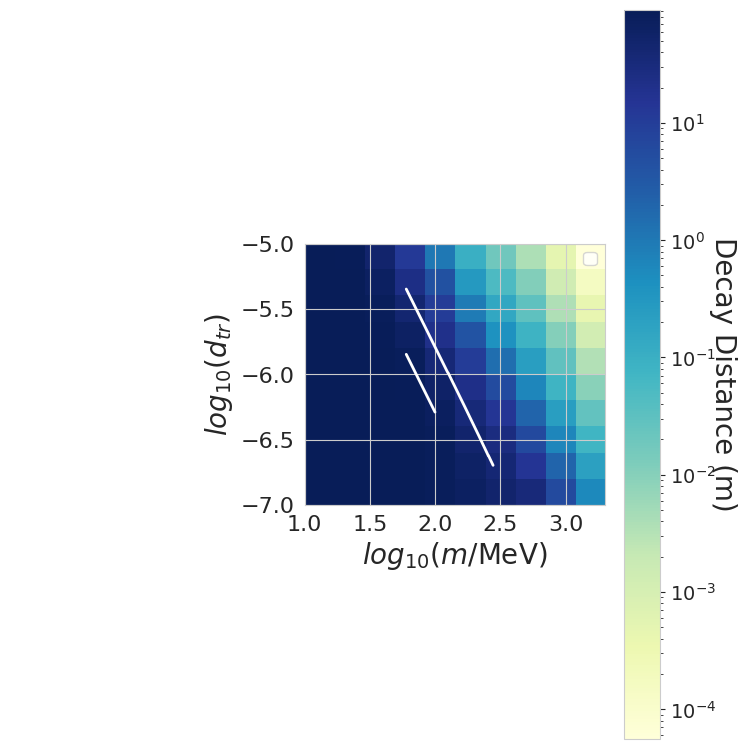

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata

plt.rcParams.update({'font.size':14,'image.cmap': 'YlGnBu'})

def read_contour_data(filename):
    contours = []
    current_contour = []
    current_level = None
    
    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:  # Skip empty lines
                continue
            if line.startswith("Contour Level:"):
                if current_contour:
                    contours.append((current_level, np.array(current_contour)))
                try:
                    current_level = float(line.split(":")[1].strip())
                except (IndexError, ValueError):
                    print(f"Warning: Invalid contour level line: {line}")
                    current_level = None
                current_contour = []
            else:
                try:
                    x, y = map(float, line.split())
                    current_contour.append([x, y])
                except ValueError:
                    print(f"Warning: Invalid data line: {line}")
    
    if current_contour and current_level is not None:
        contours.append((current_level, np.array(current_contour)))
    
    return contours

def read_data(filename):
    # Read the data from the file, skipping the header
    x = []; y = []; z = []
    with open(filename) as d:
        next(d)
        for line in d:
            i, ii, iii = line.strip().split()
            x.append(float(i)*1000)
            y.append(float(ii))
            z.append(float(iii))
    [x, y, z] = [np.array(x), np.array(y), np.array(z)]
    return x, y, z

def distance_pixel_plot(x, y, z):
    # Convert x and y to log scale
    x_log = np.log10(x)
    y_log = np.log10(y)

    # Create a grid for the pixel plot
    x_unique = np.unique(x_log)
    y_unique = np.unique(y_log)

    # Create a 2D array to hold the z values
    z_grid = np.full((len(y_unique), len(x_unique)), np.nan)

    # Fill the grid with z values
    for xi, yi, zi in zip(x_log, y_log, z):
        x_idx = np.argmin(np.abs(x_unique - xi))
        y_idx = np.argmin(np.abs(y_unique - yi))
        z_grid[y_idx, x_idx] = zi

    # Create the pixel plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Use LogNorm for the color scale, with a small epsilon to avoid log(0)
    epsilon = 1e-10
    im = ax.imshow(z_grid, origin='lower',
                   extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()],
                   aspect='equal', norm=LogNorm(vmin=max(np.nanmin(z_grid), epsilon)))

    # Add a logarithmic colorbar
    cbar = plt.colorbar(im, label='Decay Distance (m)')
    cbar.set_label('Decay Distance (m)', rotation=270, labelpad=15, fontsize=20)


    ax.set_xlabel('$log_{10}(m/\mathrm{MeV})$', fontsize=20)
    ax.set_ylabel('$log_{10}(d_{tr})$', fontsize=20)
    # ax.set_title('$\mathcal{N}$ Decay Distance in ND280+', fontsize=20)

    # Read contour data
    contours = read_contour_data(contour_file)

    for level, contour in contours:
        # Convert contour to log scale
        contour_log = np.log10(contour)
        
        # Plot the contour
        line, = ax.plot(contour_log[:, 0]+3, contour_log[:, 1], 'w-', linewidth=2, alpha=1)
        
        # Add label to the contour
        # Choose a point near the middle of the contour for the label
        label_point = contour_log[len(contour_log)//2]+.04
        ax.text(label_point[0], label_point[1], f'{level:.1f}'+' m', 
                color='white', fontweight='bold', fontsize=16, 
                ha='center', va='center', rotation=290)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    # plt.ylim(-6.5,-5)
    # plt.xlim(1,np.log10(2e3))
    # Add legend
    ax.legend(fontsize=12)

    # Adjust the plot to fill the figure
    plt.tight_layout()
    plt.savefig('pixel_plot_with_contours.png', dpi=300, bbox_inches='tight')
    plt.show()

# Read the data from the file
filename = "distance.txt"  
contour_file = "analytic_distance_contour.txt"
x, y, z = read_data(filename)

# You can adjust the intercept value as needed
distance_pixel_plot(x, y, z)

In [10]:
np.power(10,2)

100

In [10]:
# Kinematic distributions

def plot_kinematics(data,POT,Emax,axis,ylim_E=None,ylim_C=None,nbins=30,savestr=None):
    
    fig,ax = plt.subplots(1,2,figsize=(16,6))
    # ax[0].set_prop_cycle(color=['red', 'green', 'blue', 'orange'])
    # ax[1].set_prop_cycle(color=['red', 'green', 'blue', 'orange'])
    
    dec_flag = data["primary_type"]==5914
    fid_flag = data["in_fiducial"][dec_flag]
    
    # initial nu
    nu_flag = data["primary_type"]==14
    nu_momenta = np.squeeze(data["primary_momentum"][nu_flag])

    # N
    N_flag = data["primary_type"]==5914
    N_momenta = np.squeeze(data["primary_momentum"][N_flag])

    # gamma
    gamma_flag = data["secondary_types"]==22
    gamma_momenta = data["secondary_momenta"][gamma_flag]
    # mask out entries that are not gamma
    gamma_momenta = awk.mask(gamma_momenta, awk.num(gamma_momenta,axis=2)>0)
    gamma_momenta = np.squeeze(gamma_momenta[~awk.is_none(gamma_momenta,axis=1)])
    
    # nu out
    nuout_flag = data["secondary_types"]==5910
    nuout_momenta = data["secondary_momenta"][nuout_flag]
    # mask out entries that are not nuout
    nuout_momenta = awk.mask(nuout_momenta, awk.num(nuout_momenta,axis=2)>0)
    nuout_momenta = np.squeeze(nuout_momenta[~awk.is_none(nuout_momenta,axis=1)])

    kwargs = {"bins":np.linspace(0,Emax,nbins),
              "weights":data["event_weight"]*POT}

    # Energy
    n,bins = np.histogram(nu_momenta[:,0],**kwargs)
    ax[0].step(bins,np.append(n,n[-1]),where="post",label=r"Initial $\nu$")
    _n,bins = np.histogram(N_momenta[:,0],**kwargs)
    ax[0].step(bins,np.append(_n,_n[-1]),where="post",label=r"Upscattered $\mathcal{N}$")
    _n,bins = np.histogram(gamma_momenta[:,0],**kwargs)
    ax[0].step(bins,np.append(_n,_n[-1]),where="post",label=r"Outgoing $\gamma$")
    _n,bins = np.histogram(nuout_momenta[:,0],**kwargs)
    ax[0].step(bins,np.append(_n,_n[-1]),where="post",label=r"Outgoing $\nu$")
    
    # Angle
    def CosTheta(momenta):
        return momenta[:,axis]/np.linalg.norm(momenta[:,1:],axis=-1)
    
    kwargs["bins"] = np.linspace(-1,1,nbins)
    
    m,bins = np.histogram(CosTheta(nu_momenta),**kwargs)
    ax[1].step(bins,np.append(m,m[-1]),where="post",label=r"Initial $\nu$")
    _n,bins = np.histogram(CosTheta(N_momenta),**kwargs)
    ax[1].step(bins,np.append(_n,_n[-1]),where="post",label=r"Upscattered $\mathcal{N}$")
    _n,bins = np.histogram(CosTheta(gamma_momenta),**kwargs)
    ax[1].step(bins,np.append(_n,_n[-1]),where="post",label=r"Outgoing $\gamma$")
    _n,bins = np.histogram(CosTheta(nuout_momenta),**kwargs)
    ax[1].step(bins,np.append(_n,_n[-1]),where="post",label=r"Outgoing $\nu$")
    
    # fiducial events
    
    kwargs["weights"]=np.squeeze(kwargs["weights"]*fid_flag)
    kwargs["bins"] = np.linspace(0,Emax,nbins)
    
    # Energy [fiducial]
    _n,bins = np.histogram(nu_momenta[:,0],**kwargs)
    ax[0].step(bins,np.append(_n,_n[-1]),where="post",ls="--")
    _n,bins = np.histogram(N_momenta[:,0],**kwargs)
    ax[0].step(bins,np.append(_n,_n[-1]),where="post",ls="--")
    _n,bins = np.histogram(gamma_momenta[:,0],**kwargs)
    ax[0].step(bins,np.append(_n,_n[-1]),where="post",ls="--")
    _n,bins = np.histogram(nuout_momenta[:,0],**kwargs)
    ax[0].step(bins,np.append(_n,_n[-1]),where="post",ls="--")
    
    kwargs["bins"] = np.linspace(-1,1,nbins)
    
    _n,bins = np.histogram(CosTheta(nu_momenta),**kwargs)
    ax[1].step(bins,np.append(_n,_n[-1]),where="post",ls="--")
    _n,bins = np.histogram(CosTheta(N_momenta),**kwargs)
    ax[1].step(bins,np.append(_n,_n[-1]),where="post",ls="--")
    _n,bins = np.histogram(CosTheta(gamma_momenta),**kwargs)
    ax[1].step(bins,np.append(_n,_n[-1]),where="post",ls="--")
    _n,bins = np.histogram(CosTheta(nuout_momenta),**kwargs)
    ax[1].step(bins,np.append(_n,_n[-1]),where="post",ls="--")
    
    ax[0].plot([],[],label="All Events",color="black")
    ax[0].plot([],[],ls="--",label="Fiducial Events",color="black")
    
    ax[0].legend(loc="upper right",ncol=2)
    ax[0].semilogy()
    ax[0].set_xlabel("Energy [GeV]")
    ax[0].set_ylabel("Event Rate in %2.2e POT"%POT)
    ax[0].set_xlim(0,Emax)
    if ylim_E is not None:
        ax[0].set_ylim(ylim_E)
    
    ax[1].plot([],[],label="All Events",color="black")
    ax[1].plot([],[],ls="--",label="Fiducial Events",color="black")
    
    ax[1].legend(loc="upper left",ncol=2)
    ax[1].semilogy()
    ax[1].set_xlabel(r"$\cos \theta$")
    ax[1].set_ylabel("Event Rate in %2.2e POT"%POT)
    ax[1].set_xlim(-1,1)
    if ylim_C is not None:
        ax[1].set_ylim(ylim_C)
        
    plt.tight_layout()
    if savestr is not None:
        plt.savefig(savestr+"_kinematics.pdf",dpi=100)
    
    plt.show()
    
def position_plot(x,y,bins,labelx,labely,title):
    
    plt.hist2d(x,y,bins=bins,norm=LogNorm())
    c = plt.colorbar()
    c.set_label("Number of Generated Events")
    plt.xlabel(labelx)
    plt.ylabel(labely)
    # plt.text(0.96*bins[0][1],0.9*bins[1][-4],
    #          title,
    #          fontsize=16,
    #          bbox=dict(boxstyle="round",
    #                    ec="black",
    #                    fc="white")
    #         )
    plt.tight_layout()
    

def plot_positions(data,range1,range2,slice1="x",slice2="y",savestr=None,tag='dec', binnum=100):
    dec_flag = data["primary_type"]==5914
    fid_flag = data["in_fiducial"][dec_flag]
    weights = np.array(data['event_weight'])*POT
    
    fid_vertex = data["vertex"][data["in_fiducial"]][fid_flag]
    # mask out entries that are not fiducial
    fid_vertex = awk.mask(fid_vertex, awk.num(fid_vertex,axis=1)>0)
    fid_vertex = np.array(np.squeeze(fid_vertex[~awk.is_none(fid_vertex,axis=0)]))
    
    axis1 = {"x":0,"y":1,"z":2}[slice1]
    axis2 = {"x":0,"y":1,"z":2}[slice2]
    
    bins = (np.linspace(range1[0],range1[1],binnum),
            np.linspace(range2[0],range2[1],binnum))
    
    # for target in np.unique(np.array(data["target_type"][~dec_flag])):
    #     target_flag = np.squeeze((data["target_type"]==target)[~dec_flag])
    #     data_reduced = data[target_flag]
    #     label = target[target.find("."):target.find("Nucleus")]
    #     plt.scatter(np.array(data_reduced["vertex"][~dec_flag[target_flag]][:,0,axis1]),
    #                 np.array(data_reduced["vertex"][~dec_flag[target_flag]][:,0,axis2]),
    #                 alpha=0.5,label=label)
    # plt.xlim(bins[0][0],bins[0][-1])
    # plt.ylim(bins[1][0],bins[1][-1])
    # plt.legend(ncol=2)
    # plt.show()
    
    # position_plot(np.array(data["vertex"][~dec_flag][:,0,axis1]),
    #               np.array(data["vertex"][~dec_flag][:,0,axis2]),
    #               bins,"%s [m]"%slice1,"%s [m]"%slice2,"Upscattering Vertex")
    # plt.text( -9.5, -4.5, 'ND280+', color='black', fontsize=20, backgroundcolor='none')    

    # # if savestr is not None:
    # #     plt.savefig(savestr+"_upscattering_vertex_%s%s.pdf"%(slice1,slice2),dpi=100)
    # plt.show()
    
    fig, ax = plt.subplots()
    
    if tag == 'dec':
        position_plot(np.array(data["vertex"][dec_flag][:,0,axis1]),
                    np.array(data["vertex"][dec_flag][:,0,axis2]),
                    bins,"%s (m)"%slice1,"%s (m)"%slice2,"Decay Vertex")
    if tag == 'dec_weighted':
        position_plot(np.array(data["vertex"][dec_flag][:,0,axis1])*weights,
                    np.array(data["vertex"][dec_flag][:,0,axis2])*weights,
                    bins,"%s (m)"%slice1,"%s (m)"%slice2,"Weighted Decay Vertex")
    elif tag == 'upscat':
        position_plot(np.array(data["vertex"][~dec_flag][:,0,axis1]),
                  np.array(data["vertex"][~dec_flag][:,0,axis2]),
                  bins,"%s (m)"%slice1,"%s (m)"%slice2,"Upscattering Vertex")
    elif tag == 'fid':
        position_plot(fid_vertex[:,axis1],
                fid_vertex[:,axis2],
                bins,"%s (m)"%slice1,"%s (m)"%slice2,"Decay Vertex (Fiducial)")
                
    plt.text( -9.5, -4.0, 'ND280', color='black', fontsize=20, backgroundcolor='none')  
    plt.text( -9.5, -4.5, '$m=$%2.2e, $\mu_{tr}=$%2.2e'%(m4, tr4), 
             color='black', fontsize=14, 
             bbox=dict(boxstyle="round",
                       alpha=0.7,
                       ec="black",
                       fc="white"))

    # # if savestr is not None:
    if savestr != None:
        plt.savefig('./figures/'+savestr,dpi=100)
        
    plt.show()
    
    
  

    # if savestr is not None:
    #     plt.savefig(savestr+"_fiducial_decay_vertex_%s%s.pdf"%(slice1,slice2),dpi=100)
    # plt.show()

<>:190: SyntaxWarning: invalid escape sequence '\m'
<>:190: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1101398/2805443664.py:190: SyntaxWarning: invalid escape sequence '\m'
  plt.text( -9.5, -4.5, '$m=$%2.2e, $\mu_{tr}=$%2.2e'%(m4, tr4),


TPC4_Dipole_M1.00e-02_mu1.00e-07_example.parquet


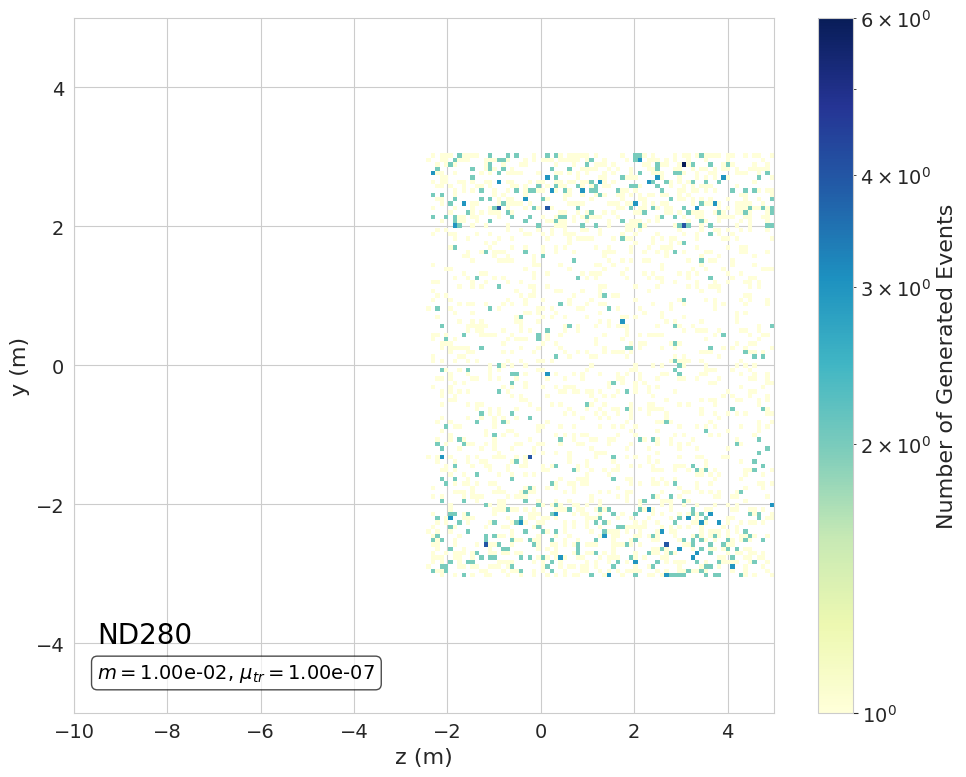

In [11]:
import os
import awkward as awk

plt.rcParams.update({'font.size':14,'image.cmap': 'YlGnBu'})

subpa = ['TPC4']


i=0
m4, tr4 = m_sample[i], mu_sample[i]

for s in subpa:
    path=s+"_Dipole_M%2.2e_mu%2.2e_example.parquet"%(m4, tr4)
    if os.path.isfile('./output/'+path):
        print(path)
        data = awk.from_parquet("output/"+path)

    Emax = 5
    axis = 3
    ylim_E = 1e6; ylim_C = 1e6
    xrange = [-5,5]; yrange = [-5,5]; zrange = [-10,5]

    plot_positions(data,zrange,yrange,"z","y",tag='upscat',binnum=160)
    
# plt.text( -9.5, -3.5, 'ND280+', color='black', fontsize=20, fontfamily='italic', backgroundcolor='none')    
# plt.text( -9.5, -4.5, '$m=$%2.2e, $\mu_{tr}=$%2.2e'%(m4, tr4), color='black', fontsize=14, backgroundcolor='none')
# plt.show()


    

In [19]:
import os
import awkward as awk
import matplotlib
matplotlib.use('Agg')  # Use the 'Agg' backend which is more stable
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import traceback
import sys
from PIL import Image

plt.rcParams.update({'font.size': 14, 'image.cmap': 'YlGnBu'})

def position_plot(x, y, bins, labelx, labely, title, ax):
    try:
        h = ax.hist2d(x, y, bins=bins, norm=LogNorm())
        # c = plt.colorbar(h[3], ax=ax)
        # c.set_label("Number of Generated Events")
        # ax.set_xlabel(labelx)
        # ax.set_ylabel(labely)
        # ax.set_title(title)
    except Exception as e:
        print(f"Error in position_plot: {str(e)}")
        traceback.print_exc()

def plot_positions(data, range1, range2, slice1="x", slice2="y", savestr=None, tag='dec', binnum=100, m4=None, tr4=None):
    try:
        dec_flag = data["primary_type"] == 5914
        fid_flag = data["in_fiducial"][dec_flag]
        weights = np.array(data['event_weight']) * POT  # Assume POT is defined globally
        
        fid_vertex = data["vertex"][data["in_fiducial"]][fid_flag]
        fid_vertex = awk.mask(fid_vertex, awk.num(fid_vertex, axis=1) > 0)
        fid_vertex = np.array(np.squeeze(fid_vertex[~awk.is_none(fid_vertex, axis=0)]))
        
        axis1 = {"x": 0, "y": 1, "z": 2}[slice1]
        axis2 = {"x": 0, "y": 1, "z": 2}[slice2]
        
        bins = (np.linspace(range1[0], range1[1], binnum),
                np.linspace(range2[0], range2[1], binnum))
        
        fig, ax = plt.subplots(figsize=(5.5, 5))
        
        if tag == 'upscat':
            position_plot(np.array(data["vertex"][~dec_flag][:, 0, axis1]),
                          np.array(data["vertex"][~dec_flag][:, 0, axis2]),
                          bins, f"{slice1} (m)", f"{slice2} (m)", "Upscattering Vertex", ax)
        
        # ax.text(-9.5, -4.0, 'ND280+', color='black', fontsize=10, backgroundcolor='none')
        ax.text(-4.3, -4.5, f'$m=${m4:.2e}, $\mu_{{tr}}=${tr4:.2e}', 
                color='black', fontsize=7, 
                bbox=dict(boxstyle="round", alpha=0.7, ec="black", fc="white"))
        
        plt.tight_layout()
        plt.savefig(savestr, dpi=100)
        plt.close()
    except Exception as e:
        print(f"Error in plot_positions: {str(e)}")
        traceback.print_exc()

def generate_individual_plots(index):
    if not os.path.exists('individual_plots'):
        os.makedirs('individual_plots')

    for i in index:
        m4, tr4 = m_sample[i], mu_sample[i]
        
        path = f"OGTPC3_Dipole_M{m4:.2e}_mu{tr4:.2e}_example.parquet"
        
        if os.path.isfile('./output/' + path):
            print(f"Processing file: {path}")
            data = awk.from_parquet("output/" + path)
            
            zrange = [-5, 5]
            yrange = [-5, 5]
            
            savestr = f'individual_plots/plot_{i:03d}.png'
            plot_positions(data, zrange, yrange, "z", "y", savestr=savestr, tag='upscat', binnum=160, m4=m4, tr4=tr4)
        else:
            print(f"File not found: {path}")

def create_grid_image():
    images = []
    for i in range(100):
        img_path = f'individual_plots/plot_{i:03d}.png'
        if os.path.exists(img_path):
            img = Image.open(img_path)
            images.append(img)
        else:
            print(f"Image not found: {img_path}")
    
    if len(images) == 0:
        print("No images found to create grid.")
        return

    grid_size = int(np.ceil(np.sqrt(len(images))))
    grid_img = Image.new('RGB', (grid_size * images[0].width, grid_size * images[0].height))

    for i, img in enumerate(images):
        row = i // grid_size
        col = i % grid_size
        grid_img.paste(img, (col * img.width, row * img.height))

    grid_img.save('grid_plot.png')
    print("Grid image saved as grid_plot.png")

# Generate sample data (replace with your actual data)
# ND280 FORWARD POT 
# POT = 12.34e20
# ND280+ FORWARD POT
POT = 2.6098758621e22


# Assume POT is defined globally
index = np.arange(0,51)
m_test = m_sample[index]
mu_test = mu_sample[index]

try:
    generate_individual_plots(index)
    create_grid_image()
except Exception as e:
    print(f"Error in main execution: {str(e)}")
    traceback.print_exc()

print("Script completed.")

<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1205550/1505461832.py:50: SyntaxWarning: invalid escape sequence '\m'
  ax.text(-4.3, -4.5, f'$m=${m4:.2e}, $\mu_{{tr}}=${tr4:.2e}',


Processing file: OGTPC3_Dipole_M1.00e-02_mu1.00e-07_example.parquet
Processing file: OGTPC3_Dipole_M1.80e-02_mu1.00e-07_example.parquet
Processing file: OGTPC3_Dipole_M3.25e-02_mu1.00e-07_example.parquet
Processing file: OGTPC3_Dipole_M5.85e-02_mu1.00e-07_example.parquet
Processing file: OGTPC3_Dipole_M1.05e-01_mu1.00e-07_example.parquet
Processing file: OGTPC3_Dipole_M1.90e-01_mu1.00e-07_example.parquet
Processing file: OGTPC3_Dipole_M3.42e-01_mu1.00e-07_example.parquet
Processing file: OGTPC3_Dipole_M6.16e-01_mu1.00e-07_example.parquet
Processing file: OGTPC3_Dipole_M1.11e+00_mu1.00e-07_example.parquet
Processing file: OGTPC3_Dipole_M2.00e+00_mu1.00e-07_example.parquet
Processing file: OGTPC3_Dipole_M1.00e-02_mu1.67e-07_example.parquet
Processing file: OGTPC3_Dipole_M1.80e-02_mu1.67e-07_example.parquet
Processing file: OGTPC3_Dipole_M3.25e-02_mu1.67e-07_example.parquet
Processing file: OGTPC3_Dipole_M5.85e-02_mu1.67e-07_example.parquet
Processing file: OGTPC3_Dipole_M1.05e-01_mu1.67e